In [6]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import sympy as sym

###Data Importing


Dataframe setup:

In [9]:
# Loads raw founder data
successful_enriched_linkedin_profiles = pd.read_csv('data/success_enriched_linkedin_profiles.csv')
fail_enriched_linkedin_profiles = pd.read_csv('data/fail_enriched_linkedin_profiles.csv')

In [10]:
# Checks for erroneous entries, removes them and resets indexing
successful_enriched_linkedin_profiles = successful_enriched_linkedin_profiles.dropna()
successful_enriched_linkedin_profiles = successful_enriched_linkedin_profiles.reset_index(drop=True)

fail_enriched_linkedin_profiles = fail_enriched_linkedin_profiles.dropna()
fail_enriched_linkedin_profiles = fail_enriched_linkedin_profiles.reset_index(drop=True)

# dfs for extracted data for successful and unsuccessful founders
success = pd.DataFrame(columns = ['linkedin_url','educations','employments'])
success['linkedin_url'] = successful_enriched_linkedin_profiles['linkedin_url']

fail = pd.DataFrame(columns = ['linkedin_url','educations','employments'])
fail['linkedin_url'] = fail_enriched_linkedin_profiles['linkedin_url']

Importing and cleaning data to extract founding dates

In [11]:
# For correlating URL with org ID (both success and fail)
LinkedInURLsS = pd.read_csv('data/Moneyball 1.1_ success - Founder Linkedin URLs.csv')
LinkedInURLsS = LinkedInURLsS.drop(['org_name'],axis = 1)
LinkedInURLsF = pd.read_csv('data/Moneyball 1.1_ fail - Founder Linkedin URLs.csv')
LinkedInURLsF = LinkedInURLsF.drop(['org_name'],axis = 1)

# For correlating org ID with founding date
CompaniesS = pd.read_csv('data/Moneyball 1.1_ success - Company.csv')
CompaniesS = CompaniesS[['org_uuid', 'founded_on']]
CompaniesF = pd.read_csv('data/Moneyball 1.1_ fail - Company.csv')
CompaniesF = CompaniesF[['org_uuid', 'founded_on']]

###Data Extraction:

####Degree type classifier:



In [12]:
def classify_degree_type(degree_type):
    # Define the categories we want to classify degrees into
    # Note if equal mentions of multiple categories, lowest index selected
    categories = {
        0: "N/A",
        1: "Bachelor",
        2: "Master",
        3: "PhD"
    }
    
    # Detects which category has the highest count
    best_category = max(categories, key=lambda x: degree_type.count(categories[x]))
    # Converts index into category name
    output = categories[best_category]
    # Converts 'N/A' to None for ease of manipulation
    if output == 'N/A':
      output = None
    return output

Degree subject classifier:

In [13]:
# Identical to above but with subject types
def classify_degree_subject(degree_subject):
  # Note if equal mentions of multiple categories, lowest index selected
  # In upper and lower case due to different formats in data
  categories = {
      0: "N/A",
      1: "Computer Science",
      2: "Engineering",
      3: "Math",
      4: "Economics",
      5: "Physics",
      6: "Chemistry",
      7: "Finance",
      8: "Business",
      9: "Management",
      10: "Marketing",
      11: "Biology",
      12: "Science",
      13: "computer science",
      14: "engineering",
      15: "math",
      16: "economics",
      17: "physics",
      18: "chemistry",
      19: "finance",
      20: "business",
      21: "management",
      22: "marketing",
      23: "biology",
      24: "science"
  }

  best_category = max(categories, key=lambda x: degree_subject.count(categories[x]))
  if best_category > 12:
    best_category = best_category - 12
  output = categories[best_category]
  if output == 'N/A':
    output = None
  return output

Define function to convert datetime values into yearfrac

In [14]:
# Takes timestamp and converts to a yearfrac
def year_frac(Date):
    # Creates timestamp at start of year
    start = datetime(Date.year, 1, 1).toordinal()
    # length of year
    year_length = datetime(Date.year+1, 1, 1).toordinal() - start
    # Returns year + the fraction of the way through the year
    return Date.year + float(Date.toordinal() - start) / year_length

Define function to give founding date of startup

In [15]:
def founding_date(index, dtype = ('success', 'fail')):

  # Chooses dfs based on dtype
  if dtype == 'success':
    link = success['linkedin_url'][index]
    LinkedInURLs = LinkedInURLsS
    Companies = CompaniesS
  elif dtype == 'fail':
    link = fail['linkedin_url'][index]
    LinkedInURLs = LinkedInURLsF
    Companies = CompaniesF

  # Finds attached org id
  org = LinkedInURLs['org_uuid'][link == LinkedInURLs['founder_linkedin_url']]
  # Sets as standard string (no pd metadata)
  org = org.values[0]
  # Finds attached founding date
  founded = Companies['founded_on'][org == Companies['org_uuid']]
  # Splits into array [month, day, year] (would need zero padding otherwise)
  founded = founded.values[0].split('/')
  # Sets to datetime and finds year frac
  founded = datetime(int(founded[2]),int(founded[0]),int(founded[1]))
  # + 2000 since year given as last two digits of year (e.g. 2017 given as 17)
  return year_frac(founded) + 2000

Extracting education data

In [16]:
def education_extraction(enriched_linkedin_profiles, output, dtype = ('success','fail')):
  # Loops through each founder
  for i in range(len(enriched_linkedin_profiles)):
      # Must extract each json individually
      current = json.loads(enriched_linkedin_profiles['json_string'][i])
      # List of education data for each founder
      education_list = []

      # Check to see if data is empty - json does not play well with for loops
      if len(current['data']) > 0:
        # Checks if educations exist
        if 'educations' in current['data'][0]:
            # Finds date when company founded
            founded = founding_date(i, dtype)

            # Loops through educational experiences listed
            for j in range(len(current['data'][0]['educations'])):
                # Default values
                From = None
                To = None
                degree = None
                subject = None

                # If from and to dates exist, collects them and adds them to a list of dates for this founder
                if 'from' in current['data'][0]['educations'][j]:
                    # If there is an error with the timestamp, does not include listing
                    try:
                      # Takes timestamp and converts into yearfrac for from and to
                      From = year_frac(datetime.fromtimestamp(current['data'][0]['educations'][j]['from']['timestamp']/1000))
                      if 'to' in current['data'][0]['educations'][j]:
                        To = year_frac(datetime.fromtimestamp(current['data'][0]['educations'][j]['to']['timestamp']/1000))

                      # Eliminates any education following founding
                      if From < founded:
                        # Gives key for degree type
                        if 'degree' in current['data'][0]['educations'][j] and 'name' in current['data'][0]['educations'][j]['degree']:
                            degree = classify_degree_type(current['data'][0]['educations'][j]['degree']['name'])
                        # Gives key for degree subject
                        if 'major' in current['data'][0]['educations'][j] and 'name' in current['data'][0]['educations'][j]['major']:
                            subject = classify_degree_subject(current['data'][0]['educations'][j]['major']['name'])
                            
                        # If job started before founding, adds education info to list
                        education_list.append([From,To,degree,subject])

                    except:
                      # If error, gives founder index and education index
                      print(f'Error in {i}: {j}')


      # Adds full list of education info for each founder to df
      output['educations'][i] = education_list

In [17]:
# Runs above function for each dataset
education_extraction(successful_enriched_linkedin_profiles, success, 'success')
education_extraction(fail_enriched_linkedin_profiles, fail, 'fail')

Error in 525: 1
Error in 630: 0
Error in 630: 1
Error in 630: 2
Error in 885: 0
Error in 1043: 1
Error in 1073: 0
Error in 1657: 3
Error in 1657: 4
Error in 1722: 2
Error in 1776: 2
Error in 1844: 0
Error in 1851: 1
Error in 1893: 3
Error in 2142: 1
Error in 2142: 2
Error in 2383: 6
Error in 2383: 7
Error in 2404: 1
Error in 2571: 0
Error in 2571: 1
Error in 2571: 2
Error in 2571: 3
Error in 2621: 2
Error in 2667: 0
Error in 2667: 1
Error in 3405: 2
Error in 3449: 1
Error in 3669: 5
Error in 3897: 6
Error in 59: 1
Error in 127: 1
Error in 127: 2
Error in 130: 2
Error in 614: 1
Error in 693: 2
Error in 903: 9
Error in 1004: 0
Error in 1086: 0
Error in 1125: 3
Error in 1375: 0
Error in 1531: 1
Error in 1550: 2
Error in 1648: 2
Error in 1648: 3
Error in 1701: 1
Error in 1755: 0
Error in 1755: 1
Error in 1926: 2
Error in 1954: 1
Error in 2234: 4
Error in 2238: 2
Error in 2245: 4
Error in 2537: 2
Error in 2541: 1
Error in 2643: 0
Error in 2643: 1
Error in 2644: 1
Error in 2697: 14
Error in 

Extracting employment data

In [18]:
def employment_extraction(enriched_linkedin_profiles, output, dtype = ('success','fail')):
  # Loops over each founder
  for i in range(len(enriched_linkedin_profiles)):
      # Must extract each json individually
      current = json.loads(enriched_linkedin_profiles['json_string'][i])
      # List of employment data for each founder
      employment_list = []

      # Check to see if data is empty - json does not play well with for loops
      if len(current['data']) > 0:
        # Checks if employments exist
        if 'employments' in current['data'][0]:
          # Finds date when company founded
          founded = founding_date(i, dtype)

          # Loops over employments listed
          for j in range(len(current['data'][0]['employments'])):
            # Default values
            From = None
            To = None
            
            # If from and to dates exist, collects them and adds them to a list of dates for this founder
            if 'from' in current['data'][0]['employments'][j]:
              # If there is an error with the timestamp, does not include listing
              try:
                # Takes timestamp and converts into yearfrac for from and to
                From = year_frac(datetime.fromtimestamp(current['data'][0]['employments'][j]['from']['timestamp']/1000))   
                if 'to' in current['data'][0]['employments'][j]:
                  To = year_frac(datetime.fromtimestamp(current['data'][0]['employments'][j]['to']['timestamp']/1000))

                # Eliminates any jobs following founding
                if From < founded:
                  # Adds job info to list
                  employment_list.append([From,To])
              
              except:
                # If error, gives founder index and education index
                print(f'Error in {i}: {j}')
      
      # adds full list of education dates for each founder to df
      output['employments'][i] = employment_list

In [19]:
# Runs above function for each dataset
employment_extraction(successful_enriched_linkedin_profiles, success, 'success')
employment_extraction(fail_enriched_linkedin_profiles, fail, 'fail')

Error in 2104: 9
Error in 2111: 10
Error in 2185: 2
Error in 2383: 12
Error in 2442: 8
Error in 2442: 9
Error in 2442: 10
Error in 3791: 22
Error in 635: 17
Error in 635: 18
Error in 1086: 5
Error in 1484: 5
Error in 1496: 12
Error in 1550: 15
Error in 1550: 16
Error in 1764: 7
Error in 2829: 6
Error in 3003: 10
Error in 3513: 11
Error in 3929: 3
Error in 4180: 4
Error in 4212: 1
Error in 4336: 0
Error in 4336: 1
Error in 4531: 5
Error in 4820: 1
Error in 4900: 6
Error in 4900: 7
Error in 5069: 1
Error in 5069: 2
Error in 5590: 13
Error in 5590: 14
Error in 5590: 15
Error in 5590: 16
Error in 5590: 17
Error in 5915: 0
Error in 5915: 1
Error in 5915: 2
Error in 5915: 3
Error in 5915: 4
Error in 5915: 5
Error in 5915: 6


Extracting age data

In [20]:
def age(enriched_linkedin_profiles, output, dtype = ('success', 'fail')):
  age = np.array([])

  for i in range(len(enriched_linkedin_profiles)):
    current = json.loads(enriched_linkedin_profiles['json_string'][i])

    # In case no age data
    try:
      # Corrects to time of founding
      corrected_age = current['data'][0]['age'] + founding_date(i, dtype) - year_frac(datetime.today())
      age = np.append(age, corrected_age)
    except:
      age = np.append(age, np.nan)
  
  # In case of no data, sets age to median
  median = np.nanmedian(age)
  age = np.nan_to_num(age, nan = median)
  # Adds age column to dataframe
  output['age'] = age

In [21]:
# Runs above function for each dataset
age(successful_enriched_linkedin_profiles, success, 'success')
age(fail_enriched_linkedin_profiles, fail, 'fail')

Removing jobs and educations with start dates after end dates (dodgy data)

In [22]:
for i in range(len(success)):
  for j in range(len(success['employments'][i])):
    # Use try since end values for ongoing jobs and education is set as None (non problematic data)
    try:
      if success['employments'][i][j][0] > success['employments'][i][j][1]:
        success['employments'][i].pop(j)
    except:
      continue
  for j in range(len(success['educations'][i])):
    try:
      if success['educations'][i][j][0] > success['educations'][i][j][1]:
        success['educations'][i].pop(j)
    except:
      continue

for i in range(len(fail)):
  for j in range(len(fail['employments'][i])):
    try:
      if fail['employments'][i][j][0] > fail['employments'][i][j][1]:
        fail['employments'][i].pop(j)
    except:
      continue
  for j in range(len(fail['educations'][i])):
    try:
      if fail['educations'][i][j][0] > fail['educations'][i][j][1]:
        fail['educations'][i].pop(j)
    except:
      continue

Removing empty columns (people with no jobs or education listed on LinkedIn)

In [23]:
# List of row indexes to be dropped
drop = []
for i in range(len(success)):
  if len(success['educations'][i]) + len(success['employments'][i]) == 0:
    drop.append(i)
success = success.drop(success.index[drop])
success = success.reset_index(drop=True)

drop = []
for i in range(len(fail)):
  if len(fail['educations'][i]) + len(fail['employments'][i]) == 0:
    drop.append(i)
fail = fail.drop(fail.index[drop])
fail = fail.reset_index(drop=True)

### Data processing:

####Has PhD:

In [24]:
# successful

# One-hot encoded list of whether founders have a PhD
PhD = []
for i in range(len(success)):
  # For each founder loops through each education and sets has_phd to 1 if any education is PhD
  has_phd = 0
  for education in success['educations'][i]:
    if education[2] == 'PhD':
      has_phd = 1
  PhD.append(has_phd)

success['PhD'] = PhD
print(f'{sum(PhD)/len(PhD)*100:.1f}%  of successful founders have a PhD')

# unsuccessful

PhD = []
for i in range(len(fail)):
  has_phd = 0
  for education in fail['educations'][i]:
    if education[2] == 'PhD':
      has_phd = 1
  PhD.append(has_phd)

fail['PhD'] = PhD
print(f'{sum(PhD)/len(PhD)*100:.1f}%  of unsuccessful founders have a PhD')

15.2%  of successful founders have a PhD
12.1%  of unsuccessful founders have a PhD


####Has Master's

In [25]:
# Identical to above

# successful

masters = []
for i in range(len(success)):
  has_masters = 0
  for education in success['educations'][i]:
    if education[2] == 'Master':
      has_masters = 1
  masters.append(has_masters)

success["Master's"] = masters
print(f"{sum(masters)/len(masters)*100:.1f}%  of successful founders have a Master's")

# unsuccessful

masters = []
for i in range(len(fail)):
  has_masters = 0
  for education in fail['educations'][i]:
    if education[2] == 'Master':
      has_masters = 1
  masters.append(has_masters)

fail["Master's"] = masters
print(f"{sum(masters)/len(masters)*100:.1f}%  of unsuccessful founders have a Master's")

37.5%  of successful founders have a Master's
36.4%  of unsuccessful founders have a Master's


####Degree Subjects:

In [26]:
# List of categories and reverse index for ease of use when printing

categories = {
      0: "N/A",
      1: "Computer Science",
      2: "Engineering",
      3: "Math",
      4: "Economics",
      5: "Physics",
      6: "Chemistry",
      7: "Finance",
      8: "Business",
      9: "Management",
      10: "Marketing",
      11: "Biology",
      12: "Science"
  }
categories_index = {
      None: 0,
      "Computer Science": 1,
      "Engineering": 2,
      "Math": 3,
      "Economics": 4,
      "Physics": 5,
      "Chemistry": 6,
      "Finance": 7,
      "Business": 8,
      "Management": 9,
      "Marketing": 10,
      "Biology": 11,
      "Science": 12
  }

# Creating one-hot encode for degree subjects


# successful

# Array of sub-arrays for each founder
# Each sub-array is one-hot encoded subjects following above indexing
subjects_success = []
for i in range(len(success)):
  # Sub-array for each founder
  individ_subjects = [0] * len(categories)

  for education in success['educations'][i]:
    # Sets one-hot encode of relevant subject for each degree
    # [3] is index of subject in education data
    individ_subjects[categories_index[education[3]]] = 1
  
  # Adds founder's sub-array to main array
  subjects_success.append(individ_subjects)


# unsuccessful

subjects_fail = []
for i in range(len(fail)):
  individ_subjects = [0] * len(categories)

  for education in fail['educations'][i]:
    individ_subjects[categories_index[education[3]]] = 1

  subjects_fail.append(individ_subjects)


# Evaluation

# Creates 1D arrays containing the number of founders of each type who have studied the relevant degree
subject_count_success = [0] * len(categories)
subject_count_fail = [0] * len(categories)

# Must loop through subjects and then founders since the array structure does not support summing functions
for i in range(len(categories)):
  for j in range(len(success)):
    subject_count_success[i] += subjects_success[j][i]
  for j in range(len(fail)):
    subject_count_fail[i] += subjects_fail[j][i]
  print(f'{categories[i]}:\nSuccessful = {subject_count_success[i]}/{len(success)} = {subject_count_success[i]/len(success)*100:.2f}%\nUnsuccessful = {subject_count_fail[i]}/{len(fail)} = {subject_count_fail[i]/len(fail)*100:.2f}%\n')


N/A:
Successful = 2262/3864 = 58.54%
Unsuccessful = 3551/5659 = 62.75%

Computer Science:
Successful = 607/3864 = 15.71%
Unsuccessful = 484/5659 = 8.55%

Engineering:
Successful = 667/3864 = 17.26%
Unsuccessful = 905/5659 = 15.99%

Math:
Successful = 130/3864 = 3.36%
Unsuccessful = 159/5659 = 2.81%

Economics:
Successful = 285/3864 = 7.38%
Unsuccessful = 372/5659 = 6.57%

Physics:
Successful = 80/3864 = 2.07%
Unsuccessful = 104/5659 = 1.84%

Chemistry:
Successful = 97/3864 = 2.51%
Unsuccessful = 88/5659 = 1.56%

Finance:
Successful = 157/3864 = 4.06%
Unsuccessful = 214/5659 = 3.78%

Business:
Successful = 206/3864 = 5.33%
Unsuccessful = 353/5659 = 6.24%

Management:
Successful = 119/3864 = 3.08%
Unsuccessful = 249/5659 = 4.40%

Marketing:
Successful = 42/3864 = 1.09%
Unsuccessful = 140/5659 = 2.47%

Biology:
Successful = 94/3864 = 2.43%
Unsuccessful = 104/5659 = 1.84%

Science:
Successful = 162/3864 = 4.19%
Unsuccessful = 222/5659 = 3.92%



Significant subjects are CS, Maths, Chem, Business, Management, Marketing, Bio

In [27]:
# Only run once

# successful

# Creates df of subject types to be merged with main df
subject_success_df = pd.DataFrame()
for i in range(len(success)):
  subject_success_df[i] = [subjects_success[i][categories_index['Computer Science']], subjects_success[i][categories_index['Math']], subjects_success[i][categories_index['Chemistry']], subjects_success[i][categories_index['Business']], subjects_success[i][categories_index['Management']], subjects_success[i][categories_index['Marketing']], subjects_success[i][categories_index['Biology']]]

# Must be transposed to have correct orientation
subject_success_df = subject_success_df.T
# Renames columns
subject_success_df = subject_success_df.rename(columns = {0:'CS',1:'Maths',2:'Chem',3:'Business',4:'Management',5:'Marketing',6:'Bio'})
# Combines with main df
success = pd.concat([success, subject_success_df], axis = 1)


# unsuccessful

subject_fail_df = pd.DataFrame()
for i in range(len(fail)):
  subject_fail_df[i] = [subjects_fail[i][categories_index['Computer Science']], subjects_fail[i][categories_index['Math']], subjects_fail[i][categories_index['Chemistry']], subjects_fail[i][categories_index['Business']], subjects_fail[i][categories_index['Management']], subjects_fail[i][categories_index['Marketing']], subjects_fail[i][categories_index['Biology']]]
subject_fail_df = subject_fail_df.T
subject_fail_df = subject_fail_df.rename(columns = {0:'CS',1:'Maths',2:'Chem',3:'Business',4:'Management',5:'Marketing',6:'Bio'})
fail = pd.concat([fail, subject_fail_df], axis = 1)


####Removing degree type and subject so 'educations' functions properly later on

In [28]:
# Runs through each founder and their educations
for i in range(len(success)):
  for j in range(len(success['educations'][i])):
    # Sets each education array to just have start and end dates
    success['educations'][i][j] = success['educations'][i][j][0:2]
  
for i in range(len(fail)):
  for j in range(len(fail['educations'][i])):
    fail['educations'][i][j] = fail['educations'][i][j][0:2]

##### Age distribution:

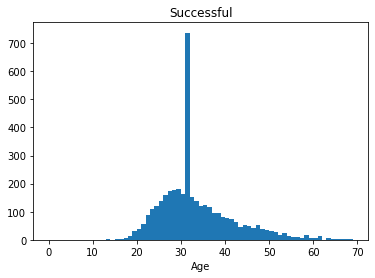

Median: 31.991780821917928

Mean:   33.70664240552934

SD:     8.44267527889094




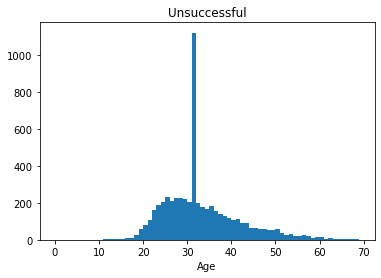

Median: 31.75751927539477

Mean:   33.51428240167527

SD:     9.020766500610046




In [29]:
# successful

# Simple histogram of age
plt.hist(success['age'], bins = np.arange(0,70,1))
plt.title('Successful')
plt.xlabel('Age')
plt.show()
print(f"Median: {success['age'].median()}\n\nMean:   {success['age'].mean()}\n\nSD:     {success['age'].std()}\n\n")


# unsuccessful

plt.hist(fail['age'], bins = np.arange(0,70,1))
plt.title('Unsuccessful')
plt.xlabel('Age')
plt.show()
print(f"Median: {fail['age'].median()}\n\nMean:   {fail['age'].mean()}\n\nSD:     {fail['age'].std()}\n\n")

####Number of Jobs:

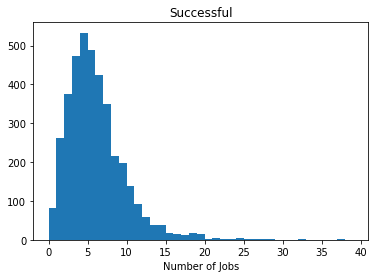

Median: 5.0

Mean:   5.5646997929606625

SD:     3.7358352741922958




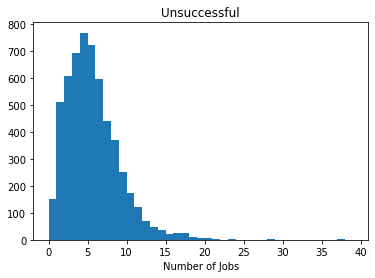

Median: 5.0

Mean:   5.199858632267185

SD:     3.6992580888233006




In [30]:
# successful

# Array of the number of jobs each founder has had before founding
numJobs = []
for i in range(len(success)):
  # Appends length of employments array
  numJobs.append(len(success['employments'][i]))
# Adds this as a feature to df
success['numJobs'] = numJobs

# Plots histogram
plt.hist(numJobs, bins = np.arange(0,40,1))
plt.title('Successful')
plt.xlabel('Number of Jobs')
plt.show()
print(f"Median: {success['numJobs'].median()}\n\nMean:   {success['numJobs'].mean()}\n\nSD:     {success['numJobs'].std()}\n\n")


# unsuccessful

numJobs = []
for i in range(len(fail)):
  numJobs.append(len(fail['employments'][i]))
fail['numJobs'] = numJobs

plt.hist(numJobs, bins = np.arange(0,40,1))
plt.title('Unsuccessful')
plt.xlabel('Number of Jobs')
plt.show()
print(f"Median: {fail['numJobs'].median()}\n\nMean:   {fail['numJobs'].mean()}\n\nSD:     {fail['numJobs'].std()}\n\n")

####Number of degrees:

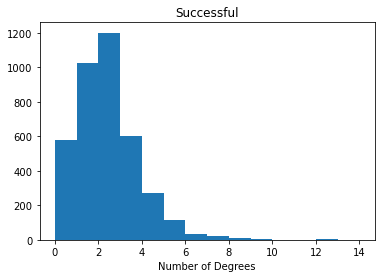

Median: 2.0

Mean:   1.9158902691511388

SD:     1.444070269471725




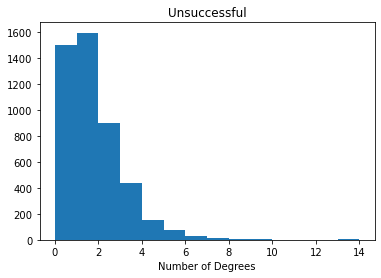

Median: 1.0

Mean:   0.9339105849089945

SD:     1.646213268785856




In [31]:
# Identical to above but for education

# successful

numDegrees = []
for i in range(len(success)):
  numDegrees.append(len(success['educations'][i]))
success['numDegrees'] = numDegrees
plt.hist(numDegrees, bins = np.arange(0,15,1))
plt.title('Successful')
plt.xlabel('Number of Degrees')
plt.show()
print(f"Median: {success['numDegrees'].median()}\n\nMean:   {success['numDegrees'].mean()}\n\nSD:     {success['numDegrees'].std()}\n\n")


# unsuccessful

numDegrees = []
for i in range(len(fail)):
  numDegrees.append(len(fail['educations'][i])-1)
fail['numDegrees'] = numDegrees
plt.hist(numDegrees, bins = np.arange(0,15,1))
plt.title('Unsuccessful')
plt.xlabel('Number of Degrees')
plt.show()
print(f"Median: {fail['numDegrees'].median()}\n\nMean:   {fail['numDegrees'].mean()}\n\nSD:     {fail['numDegrees'].std()}\n\n")

####Average length of job:

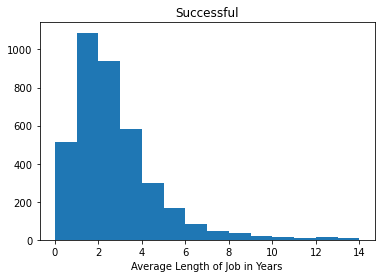

Median: 2.294117647058857

Mean:   2.8688117769632067

SD:     2.60220214143389




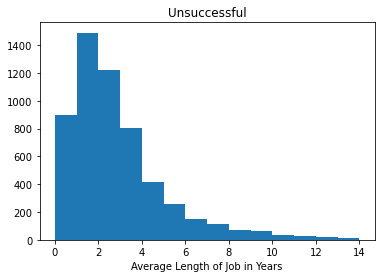

Median: 2.3137928605082085

Mean:   3.0344512199955305

SD:     2.8137096747722583




In [32]:
# successful

# Array of average job length for each founder
avLength = []
for i in range(len(success)):
  total_length = 0
  founded = founding_date(i, 'success')
  for j in range(len(success['employments'][i])):
    # End is None for current jobs
    # If job finishes after founding date, finishing date set to founding date
    if success['employments'][i][j][1] != None:
      total_length += min(founded, success['employments'][i][j][1]) - success['employments'][i][j][0]
    else:
      total_length += founded - success['employments'][i][j][0]
  # catch div 0 error
  if len(success['employments'][i]) != 0:
    avLength.append(total_length/len(success['employments'][i]))
  else:
    avLength.append(0)

# Adds feature to df
success['avLengthJob'] = avLength
plt.hist(avLength, bins = np.arange(0,15,1))
plt.title('Successful')
plt.xlabel('Average Length of Job in Years')
plt.show()
print(f"Median: {success['avLengthJob'].median()}\n\nMean:   {success['avLengthJob'].mean()}\n\nSD:     {success['avLengthJob'].std()}\n\n")


# unsuccessful

avLength = []
for i in range(len(fail)):
  total_length = 0
  founded = founding_date(i, 'fail')
  for j in range(len(fail['employments'][i])):
    if fail['employments'][i][j][1] != None:
      total_length += min(founded, fail['employments'][i][j][1]) - fail['employments'][i][j][0]
    else:
      total_length += founded - fail['employments'][i][j][0]
  if len(fail['employments'][i]) != 0:
    avLength.append(total_length/len(fail['employments'][i]))
  else:
    avLength.append(0)

fail['avLengthJob'] = avLength
plt.hist(avLength, bins = np.arange(0,15,1))
plt.title('Unsuccessful')
plt.xlabel('Average Length of Job in Years')
plt.show()
print(f"Median: {fail['avLengthJob'].median()}\n\nMean:   {fail['avLengthJob'].mean()}\n\nSD:     {fail['avLengthJob'].std()}\n\n")

####Average length of degree

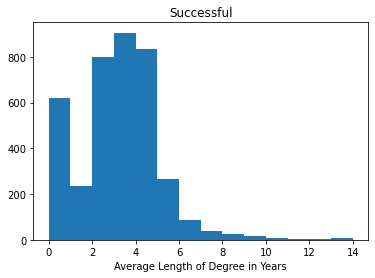

Median: 3.0

Mean:   3.024546666290871

SD:     2.273309869183097




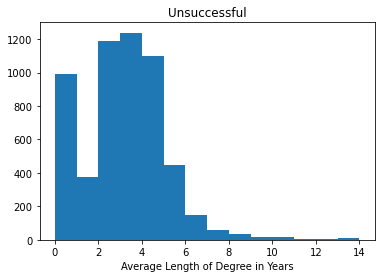

Median: 3.0

Mean:   3.000234959993108

SD:     2.5044937919880956




In [33]:
# Identical to above but for education

# successful

avLength = []
for i in range(len(success)):
  total_length = 0
  founded = founding_date(i, 'success')
  for j in range(len(success['educations'][i])):
    # end is None for current jobs
    if success['educations'][i][j][1] != None:
      total_length += min(founded, success['educations'][i][j][1]) - success['educations'][i][j][0]
    else:
      total_length += founded - success['educations'][i][j][0]
  # catch div 0 error
  if len(success['educations'][i]) != 0:
    avLength.append(total_length/len(success['educations'][i]))
  else:
    avLength.append(0)

success['avLengthDegree'] = avLength
plt.hist(avLength, bins = np.arange(0,15,1))
plt.title('Successful')
plt.xlabel('Average Length of Degree in Years')
plt.show()
print(f"Median: {success['avLengthDegree'].median()}\n\nMean:   {success['avLengthDegree'].mean()}\n\nSD:     {success['avLengthDegree'].std()}\n\n")


# unsuccessful

avLength = []
for i in range(len(fail)):
  total_length = 0
  founded = founding_date(i, 'fail')
  for j in range(len(fail['educations'][i])):
    if fail['educations'][i][j][1] != None:
      total_length += min(founded, fail['educations'][i][j][1]) - fail['educations'][i][j][0]
    else:
      total_length += founded - fail['educations'][i][j][0]
  if len(fail['educations'][i]) != 0:
    avLength.append(total_length/len(fail['educations'][i]))
  else:
    avLength.append(0)

fail['avLengthDegree'] = avLength
plt.hist(avLength, bins = np.arange(0,15,1))
plt.title('Unsuccessful')
plt.xlabel('Average Length of Degree in Years')
plt.show()
print(f"Median: {fail['avLengthDegree'].median()}\n\nMean:   {fail['avLengthDegree'].mean()}\n\nSD:     {fail['avLengthDegree'].std()}\n\n")

####Length of time from end of first education to founding:

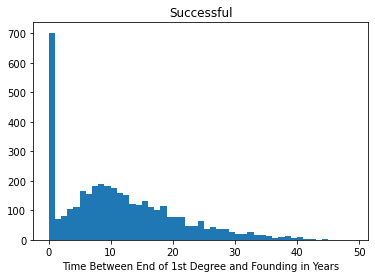

Median: 9.60684931506853

Mean:   11.019542324736081

SD:     9.183024545996433




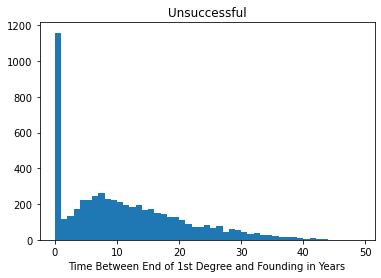

Median: 9.0

Mean:   10.785548316045794

SD:     9.503351332802172




In [34]:
# successful

# Array of time taken by each founder
timeToFound = []
for i in range(len(success)):
  founded = founding_date(i, 'success')
  # Ensures there are educations listed and date is not None
  if len(success['educations'][i]) > 0 and success['educations'][i][len(success['educations'][i])-1][1] != None:
    # Appends difference between founding date and end of first education in years
    timeToFound.append(founded - min(success['educations'][i][len(success['educations'][i])-1][1], founded))
  else:
    # Time set to 0 if no education listed
    timeToFound.append(0)

# Adds feature to df
success['timeToFound'] = timeToFound

plt.hist(timeToFound, bins = np.arange(0,50,1))
plt.title('Successful')
plt.xlabel('Time Between End of 1st Degree and Founding in Years')
plt.show()
print(f"Median: {success['timeToFound'].median()}\n\nMean:   {success['timeToFound'].mean()}\n\nSD:     {success['timeToFound'].std()}\n\n")


# unsuccessful

timeToFound = []
for i in range(len(fail)):
  founded = founding_date(i, 'fail')
  if len(fail['educations'][i]) > 0 and fail['educations'][i][len(fail['educations'][i])-1][1] != None:
    timeToFound.append(founded - min(fail['educations'][i][len(fail['educations'][i])-1][1], founded))
  else:
    timeToFound.append(0)

fail['timeToFound'] = timeToFound

plt.hist(timeToFound, bins = np.arange(0,50,1))
plt.title('Unsuccessful')
plt.xlabel('Time Between End of 1st Degree and Founding in Years')
plt.show()
print(f"Median: {fail['timeToFound'].median()}\n\nMean:   {fail['timeToFound'].mean()}\n\nSD:     {fail['timeToFound'].std()}\n\n")

####Time from end of last education to founding

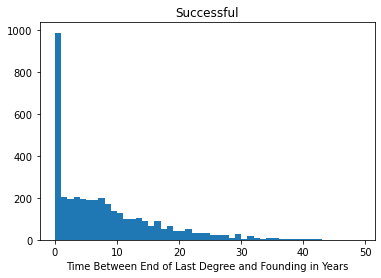

Median: 5.328767123287662

Mean:   7.584410264511012

SD:     8.04668087449748




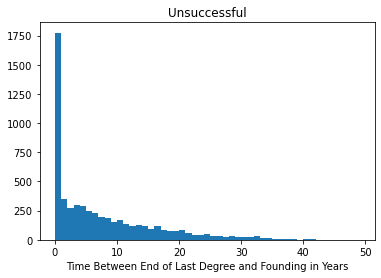

Median: 4.0

Mean:   7.093853126687667

SD:     8.266275540394409




In [35]:
# As above

# successful

timeToFound = []
for i in range(len(success)):
  founded = founding_date(i, 'success')
  # ensures there are educations listed and date is not None
  if len(success['educations'][i]) > 0 and success['educations'][i][0][1] != None:
    timeToFound.append(founded - min(success['educations'][i][0][1], founded))
  elif len(success['educations'][i]) > 1 and success['educations'][i][1][1] != None:
    timeToFound.append(founded - min(success['educations'][i][1][1], founded))
  else:
    timeToFound.append(0)

success['timeFromLastEd'] = timeToFound

plt.hist(timeToFound, bins = np.arange(0,50,1))
plt.title('Successful')
plt.xlabel('Time Between End of Last Degree and Founding in Years')
plt.show()
print(f"Median: {success['timeFromLastEd'].median()}\n\nMean:   {success['timeFromLastEd'].mean()}\n\nSD:     {success['timeFromLastEd'].std()}\n\n")


# unsuccessful

timeToFound = []
for i in range(len(fail)):
  founded = founding_date(i, 'fail')
  if len(fail['educations'][i]) > 0 and fail['educations'][i][0][1] != None:
    timeToFound.append(founded - min(fail['educations'][i][0][1], founded))
  elif len(fail['educations'][i]) > 1 and fail['educations'][i][1][1] != None:
    timeToFound.append(founded - min(fail['educations'][i][1][1], founded))
  else:
    timeToFound.append(0)

fail['timeFromLastEd'] = timeToFound

plt.hist(timeToFound, bins = np.arange(0,50,1))
plt.title('Unsuccessful')
plt.xlabel('Time Between End of Last Degree and Founding in Years')
plt.show()
print(f"Median: {fail['timeFromLastEd'].median()}\n\nMean:   {fail['timeFromLastEd'].mean()}\n\nSD:     {fail['timeFromLastEd'].std()}\n\n")

####Time from start of first job to founding:

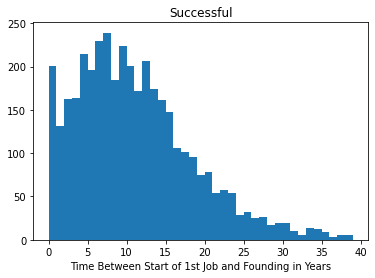

Median: 9.913238266337203

Mean:   10.950297546400215

SD:     7.453257661259594




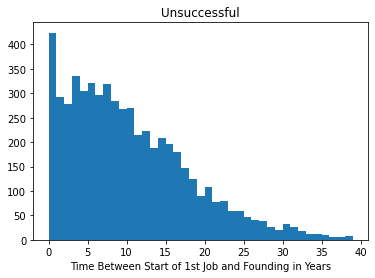

Median: 8.836065573770384

Mean:   10.301562561075075

SD:     7.831463623933636




In [36]:
# As above

# successful

timeToFound = []
for i in range(len(success)):
  # ensures there are employments listed and date is not None
  if len(success['employments'][i]) > 0:
    timeToFound.append(founding_date(i, 'success') - success['employments'][i][len(success['employments'][i])-1][0])
  else:
    timeToFound.append(0)

success['timeFromFirstJob'] = timeToFound

plt.hist(timeToFound, bins = np.arange(0,40,1))
plt.title('Successful')
plt.xlabel('Time Between Start of 1st Job and Founding in Years')
plt.show()
print(f"Median: {success['timeFromFirstJob'].median()}\n\nMean:   {success['timeFromFirstJob'].mean()}\n\nSD:     {success['timeFromFirstJob'].std()}\n\n")


# unsuccessful

timeToFound = []
for i in range(len(fail)):
  if len(fail['employments'][i]) > 0:
    timeToFound.append(founding_date(i, 'fail') - fail['employments'][i][len(fail['employments'][i])-1][0])
  else:
    timeToFound.append(0)

fail['timeFromFirstJob'] = timeToFound

plt.hist(timeToFound, bins = np.arange(0,40,1))
plt.title('Unsuccessful')
plt.xlabel('Time Between Start of 1st Job and Founding in Years')
plt.show()
print(f"Median: {fail['timeFromFirstJob'].median()}\n\nMean:   {fail['timeFromFirstJob'].mean()}\n\nSD:     {fail['timeFromFirstJob'].std()}\n\n")

####Time between finishing last job and founding:

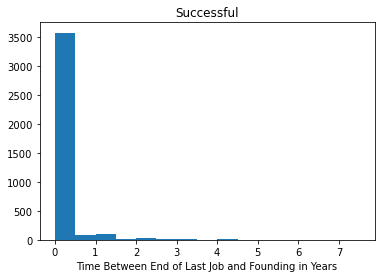

Median: 0.0

Mean:   0.16886388693999846

SD:     0.8307418161438822




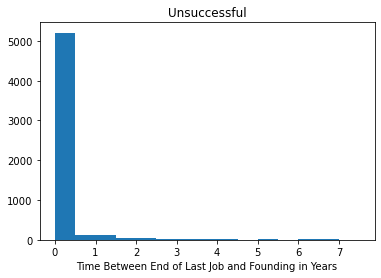

Median: 0.0

Mean:   0.19440068722982767

SD:     0.9425866718589887




In [37]:
# As above

# successful

timeFromLast = []
for i in range(len(success)):
  founded = founding_date(i, 'success')

  # ensures there are employments listed and date is not None
  if len(success['employments'][i]) > 0 and success['employments'][i][0][1] != None and founded >= success['employments'][i][0][1]:
    timeFromLast.append(founded - success['employments'][i][0][1])
  else:
    timeFromLast.append(0)

success['timeFromLastJob'] = timeFromLast

plt.hist(timeFromLast, bins = np.arange(0,8,0.5))
plt.title('Successful')
plt.xlabel('Time Between End of Last Job and Founding in Years')
plt.show()
print(f"Median: {success['timeFromLastJob'].median()}\n\nMean:   {success['timeFromLastJob'].mean()}\n\nSD:     {success['timeFromLastJob'].std()}\n\n")


# unsuccessful

timeFromLast = []
for i in range(len(fail)):
  founded = founding_date(i, 'fail')

  if len(fail['employments'][i]) > 0 and fail['employments'][i][0][1] != None and founded >= fail['employments'][i][0][1]:
    timeFromLast.append(founded - fail['employments'][i][0][1])
  else:
    timeFromLast.append(0)

fail['timeFromLastJob'] = timeFromLast

plt.hist(timeFromLast, bins = np.arange(0,8,0.5))
plt.title('Unsuccessful')
plt.xlabel('Time Between End of Last Job and Founding in Years')
plt.show()
print(f"Median: {fail['timeFromLastJob'].median()}\n\nMean:   {fail['timeFromLastJob'].mean()}\n\nSD:     {fail['timeFromLastJob'].std()}\n\n")

####Number of years unemployed (no job or education ongoing):

Looking at time from first degree/job to founding

Binary space between start and finish created - takes either 1 or 0 for employed or not.

Time set to 1 for duration of each job/education. Space is summed and scaled at the end.

In [38]:
def unemployed_time(df, index, dtype):

  employment = np.array(df['employments'][index])
  educations = np.array(df['educations'][index])

  # Collates all experiences into one np array
  # Checks in case no employment or education data - cannot append in that case
  if len(employment) > 0 and len(educations) > 0:
    activity = np.append(employment, educations,axis=0)
  elif len(employment) > 0:
    activity = employment
  elif len(educations) > 0:
    activity = educations
  # If nothing listed, unemployed time defaults to 0 (could try using KNN)
  else:
    return 0

  # Start and end dates
  end_date = founding_date(index, dtype)
  # Fixes potential None values due to ongoing jobs
  activity = np.where(activity == None, end_date, activity)
  activity = np.where(activity > end_date, end_date, activity)
  start_date = np.amin(activity)

  # Space of dates
  space = np.zeros(1000)
  # Corresponding year fracs for dates
  time = np.linspace(start_date, end_date, 1000)

  # Sets values in time space during which each education/employment occurs to 1
  for i in range(len(activity)):
    space = np.where((time >= activity[i][0]) & (time <= activity[i][1]), 1, space)

  # Sum to find time in employment
  employed_time = np.sum(space)/len(space) * (end_date - start_date)

  # Subtracts time in employment from founding date - start of first education/employment
  return end_date - start_date - employed_time

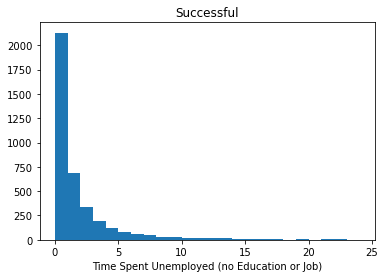

Median: 0.8261147540983558

Mean:   1.9420356276996746

SD:     3.3995909522885395




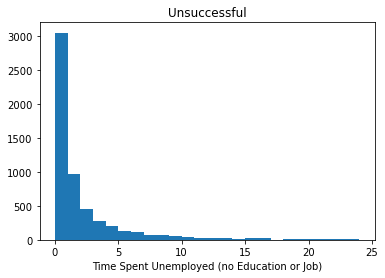

Median: 0.9000000000000021

Mean:   2.1945445315051626

SD:     3.870994149307801




In [39]:
# successful

unemployedTime = []
for i in range(len(success)):
  # Ensures there are employments/degrees listed
  if len(success['employments'][i]) + len(success['educations'][i]) > 0:
    # Calls function to find founder's unemployed time
    unemployedTime.append(unemployed_time(success, i, dtype = 'success'))
  else:
    unemployedTime.append(0)

# Adds feature to df
success['unemployedTime'] = unemployedTime

plt.hist(unemployedTime, bins = np.arange(0,25,1))
plt.title('Successful')
plt.xlabel('Time Spent Unemployed (no Education or Job)')
plt.show()
print(f"Median: {success['unemployedTime'].median()}\n\nMean:   {success['unemployedTime'].mean()}\n\nSD:     {success['unemployedTime'].std()}\n\n")


# unsuccessful

unemployedTime = []
for i in range(len(fail)):
  if len(fail['employments'][i]) + len(fail['educations'][i]) > 0:
    unemployedTime.append(unemployed_time(fail, i, dtype = 'fail'))
  else:
    unemployedTime.append(0)

fail['unemployedTime'] = unemployedTime
plt.hist(unemployedTime, bins = np.arange(0,25,1))
plt.title('Unsuccessful')
plt.xlabel('Time Spent Unemployed (no Education or Job)')
plt.show()
print(f"Median: {fail['unemployedTime'].median()}\n\nMean:   {fail['unemployedTime'].mean()}\n\nSD:     {fail['unemployedTime'].std()}\n\n")

####Number of jobs at the same time as founding:

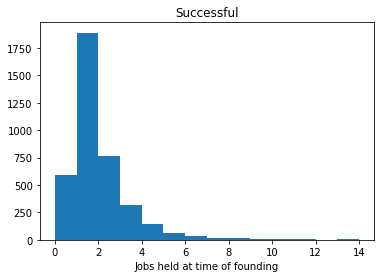

Median: 1.0

Mean:   1.5586028460543337

SD:     1.5650968238928862




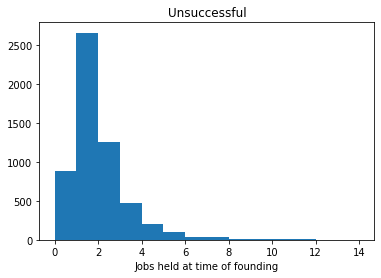

Median: 1.0

Mean:   1.5283619013960064

SD:     1.4122249363727555




In [ ]:
# successful

simulJobs = []
for i in range(len(success)):
  founded = founding_date(i, 'success')
  # Counter for number of jobs at same time as founding
  jobs = 0

  for j in range(len(success['employments'][i])):
    # Increases jobs if job continued after founding (note all jobs started after founding not included in data)
    if success['employments'][i][j][1] == None or success['employments'][i][j][1] >= founded:
      jobs += 1

  simulJobs.append(jobs)

# Adds feature to df
success['simulJobs'] = simulJobs

plt.hist(simulJobs, bins = np.arange(0,15,1))
plt.title('Successful')
plt.xlabel('Jobs held at time of founding')
plt.show()
print(f"Median: {success['simulJobs'].median()}\n\nMean:   {success['simulJobs'].mean()}\n\nSD:     {success['simulJobs'].std()}\n\n")


# unsuccessful

simulJobs = []
for i in range(len(fail)):
  founded = founding_date(i, 'fail')
  jobs = 0

  for j in range(len(fail['employments'][i])):

    if fail['employments'][i][j][1] == None or fail['employments'][i][j][1] >= founded:
      jobs += 1

  simulJobs.append(jobs)

fail['simulJobs'] = simulJobs
plt.hist(simulJobs, bins = np.arange(0,15,1))
plt.title('Unsuccessful')
plt.xlabel('Jobs held at time of founding')
plt.show()
print(f"Median: {fail['simulJobs'].median()}\n\nMean:   {fail['simulJobs'].mean()}\n\nSD:     {fail['simulJobs'].std()}\n\n")

###Data Exporting:

Combines success and fail into single df with success value (1 or 0)

In [ ]:
# Creates success/fail labels
success['success'] = np.ones(len(success))
fail['success'] = np.zeros(len(fail))

# Combines dataframes
data_features = pd.concat([success,fail])
# Drops columns which do not directly contain useful features
data_features = data_features.drop(['linkedin_url', 'educations', 'employments'], axis = 1)

Saves features as a csv file without unnecessary data

In [ ]:
# Alter this as appropriate for the desired file save path

# weird stuff so that files save to where I want on Google Drive
with open('data/features.csv', 'w', encoding = 'utf-8-sig') as f:
  data_features.to_csv(f, index = False)

###Data Structure:

All data is based on scraped LinkedIn pages and only accounts for events/experiences before founding

age: age at the time of founding

PhD: 1 for has PhD, 0 otherwise

Master's: 1 for has master's, 0 otherwise

Degree Subjects: One-hot encoded

numJobs: total number of jobs held

numDegrees: total number of education experiences on LinkedIn

avLength: average length of each job held

avLengthDegree: average length of each education experience

timeToFound: time from finishing first listed education to founding

timeFromLastEd: time from finishing last listed education to founding

timeFromFirstJob: time from starting first job to founding

timeFromLastJob: time from finishing last job to founding

unemployedTime: time spent between first education experience and founding with no ongoing education or job listed

In [ ]:
success.drop(['linkedin_url', 'educations', 'employments'], axis = 1).head()

,age,PhD,Master's,CS,Maths,Chem,Business,Management,Marketing,Bio,...,numDegrees,avLengthJob,avLengthDegree,timeToFound,timeFromLastEd,timeFromFirstJob,timeFromLastJob,unemployedTime,simulJobs,success
0,33.778082,0,1,1,0,0,0,0,0,0,...,1,1.957650,6.0,5.0,5.0,4.584699,0.669399,1.089,0,1.0
1,27.778082,0,0,0,0,0,0,0,0,0,...,1,1.584247,3.0,7.0,7.0,7.504110,0.000000,0.920,1,1.0
2,24.778082,0,0,0,0,0,0,0,0,0,...,1,1.001145,4.0,3.0,3.0,1.419178,0.418033,2.002,0,1.0
3,37.778082,0,0,0,0,0,0,0,0,0,...,2,2.685460,5.0,21.0,18.0,12.418033,0.000000,6.412,5,1.0
4,32.778082,0,0,0,0,0,0,0,0,0,...,4,3.388026,2.5,16.0,12.0,15.000000,0.000000,0.756,1,1.0
